In [1]:
%matplotlib inline
import numpy as np
from IPython.display import clear_output
from numpy import linalg as LA
import matplotlib.pyplot as pl
import matplotlib
from mpl_toolkits.mplot3d.axes3d import Axes3D

from scipy.optimize import minimize
from scipy import optimize
import f_class
from GP import GP
from GP_grad import GP_grad
from lineGD import lineGD
import time
from torch.quasirandom import SobolEngine
import sobol_seq
from utils import *

eps = np.sqrt(np.finfo(float).eps)

Noise = False
Noise_level = 0.00 # noise-free

#### High-dimensional $f$

In [2]:
objective = f_class.Hartmann_6(Noise, Noise_level)
objective = f_class.Ackley(Noise, Noise_level, dim=10)
# objective = f_class.Michalewicz(Noise, Noise_level)
# objective = f_class.Schwefel(Noise, Noise_level, dim=20)
# objective = f_class.Rosenbrock(Noise, Noise_level)
# objective = f_class.Griewank(Noise, Noise_level)
# objective = f_class.Levy(Noise, Noise_level, dim=10) 
# objective = f_class.Rastrigin(Noise, Noise_level, dim=10)
# objective = f_class.Shubert_2(Noise, Noise_level)
# objective = f_class.Ackley_2(Noise, Noise_level)

f = objective.func
clean_f = lambda x: f_class.Hartmann_6().func(x)
clean_f = lambda x: f_class.Ackley(dim=10).func(x)
# clean_f = lambda x: f_class.Michalewicz().func(x)
# clean_f = lambda x: f_class.Schwefel(dim=20).func(x)
# clean_f = lambda x: f_class.Rosenbrock().func(x)
# clean_f = lambda x: f_class.Griewank().func(x)
# clean_f = lambda x: f_class.Levy(dim=10).func(x)
# clean_f = lambda x: f_class.Rastrigin(dim=10).func(x)
# clean_f = lambda x: f_class.Shubert_2().func(x)
# clean_f = lambda x: f_class.Ackley_2().func(x)  

B = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
print(B.T) 
lb = B[:, 0]; ub = B[:, 1]

dim = objective.input_dim
print('dim: ', dim)
# print(f( np.array([dim*[1], dim*[1]])))

[[-5. -5. -5. -5. -5. -5. -5. -5. -5. -5.]
 [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]]
dim:  10


In [3]:
# assuming B = L^d, cube
Diam = LA.norm(ub - lb)
Len = (ub - lb)[0]
Diam

47.43416490252569

#### Finding Optimized Hyperparameter $\sigma, \ell \rightarrow$ Online Update of Hyperparameter

In [4]:
# set seed
seed = 0
def random_draw(n_random_draws=3):
    """ samples some points"""
    # should draw randomly
    return np.random.uniform(lb, ub, size=(n_random_draws, dim))

def optimize_hyper(lb, ub, sample_size=2000):
#     np.random.seed(seed)
    X = np.asarray(np.random.uniform(lb, ub, size=(sample_size, dim)))
    gp.set_data(X, f(X))
    ls, var = gp.optimize()
    gp.clear()
    return (ls, var)

# # find optimized hyper, if online, skip this part
# gp = GP_grad(B, Noise, Noise_level)
# (ls, var) = optimize_hyper(lb, ub, sample_size=2000)
# del gp
# (ls, var)

### Grid

In [5]:
# n_Grid = dim
# G = np.zeros((dim, n_Grid))
# for i in range(dim):
#     G[i] = np.linspace(lb[i], ub[i], n_Grid)

# Grid = np.vstack( [axis.flatten() for axis in np.meshgrid(*(G[i] for i in range(G.shape[0])))] ).T
# Grid.shape

### Grid Approx Gradient

In [6]:
# # approximate the gradient
# from scipy import optimize

# eps = np.sqrt(np.finfo(float).eps)
# approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
# approx_grad.shape

In [7]:
# # 3d plot of the gradient
# # approximate the gradient
# from scipy import optimize

# # optimize.approx_fprime(x, clean_Ackley_1d, eps)
# eps = np.sqrt(np.finfo(float).eps)
# approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
# approx_grad.shape
# g1 = approx_grad[:, 0]
# g2 = approx_grad[:, 1]
# g1, g2

### Trust Region GD-1

In [8]:
MAX = 200 # function observations

##### 1. Setup with random points

In [9]:
# initial data
setup = 20
# X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
X = from_unit_cube(latin_hypercube(setup, dim), lb, ub)
X_fix = X

history = [(x, f(x)) for x in X]

##### 2. Build Trust Region 

In [10]:
# return x inside trust region ball
def build_TR(X, TR_c, TR_r):
    X_TR = np.vstack(list(filter(lambda x: LA.norm(x - TR_c) < TR_r, [x for x in X])))
    return X_TR

In [11]:
# R = 0.5 * Diam
# X_TR = build_TR(X, X[0], R)

# pl.figure(figsize=(6, 6), dpi=80)
# pl.plot(X[:, 0], X[:, 1], 'o', linewidth=1, markersize=8)
# pl.plot(X_TR[:, 0], X_TR[:, 1], 'x', linewidth=2, markersize=8)
# pl.xlim(B[0])
# pl.ylim(B[1])

# pl.gca().add_patch(pl.Circle(X[0], R, color='blue', alpha=0.1))
# pl.show()

### Trust Region GD-1

In [12]:
np.set_printoptions(precision=4)
cost = setup
# gp.posterior(w), gp._normal(f(w))
# gp.grad(w), gp.grad_sample(w), optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps)

In [13]:
# plot
n_Grid = 100
x1 = np.linspace(lb[0], ub[0], n_Grid)
x2 = np.linspace(lb[1], ub[1], n_Grid)

X1, X2 = np.meshgrid(x1, x2)
Grid = np.vstack((X1.flatten(), X2.flatten())).T
Grid.shape

(10000, 2)

In [15]:
MAX_Fal = 10
MAX_Imp = 2

R0 = 0.8 * Diam

MAX_R = R0
MIN_R = (1/2)**4 * R0
xc = X[np.argmin(f(X))]
MIN_R, MAX_R

# L0: starting length of trust region
R0 = MIN_R
R0, MIN_R
R = R0
R

2.3717082451262845

In [20]:
while MAX >= cost:
    print('.... new lineBO')
    # re-start
    if cost != setup:
        R = R0
        XS = from_unit_cube(latin_hypercube(setup, dim), lb, ub)
        xc = X[np.argmin(f(XS))]
        X = np.vstack([X, XS])
        cost += setup
    
    f_xc = f(xc)
    GD_Fal = 0
    GD_Imp = 0
    
    while MAX >= cost:
        print(cost, end = '. ')
        print('R = ', R)
        
        # new TR = (xc, R)
        Xtr = build_TR(X, xc, R)  # get the points only inside the trust region
        
        # fit a new GP with pts inside TR
        gp = GP_grad(B, Noise, Noise_level, compress=True)
        gp.set_data(Xtr, f(Xtr))
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        gp.fit()
        
        # GD from xc to get new x
        GD = lineGD(gp, xc, f, R)
        x, _ = GD.update(commit=True)
        X = np.vstack([X, x])
        cost += 1

        # update GD_Fal & GD_Imp
        delta = 0 # np.abs(1e-3 * f_xc)
        if f(x) < f_xc - delta:
            GD_Fal = 0
            GD_Imp += 1
        else:
            GD_Fal += 1
            GD_Imp = 0
            
        if f(x) < f_xc:
            # shift xc
            xc = x
            f_xc = f(xc)
            
        # tune xc a little
        gp.add_data(x, f(x))
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        gp.fit()

        prev_xc = xc
        print(f(prev_xc))
        for i in range(10):
            lr = (1/2)**10 * R0
            gt = gp.grad_sample(xc)
            gt = gt / LA.norm(gt)
            xc = np.clip(xc - lr * gt, lb, ub)
            
        R = R + LA.norm(xc - prev_xc)
        print(f(xc))
        
        # update R
        if MAX_Fal == GD_Fal:
            R = max(R / 2, MIN_R)
            GD_Fal = 0
            print('Shrink the region: %.4f ' % R)

        if MAX_Imp == GD_Imp:
            R = min(R * 2, MAX_R)
            GD_Imp = 0
            print('Expand the region: %.4f ' % R)
            
        if R <= MIN_R and GD_Fal >= MAX_Fal:
            break  
            
        # plot
#         pl.figure(figsize=(6, 6), dpi=80)
#         pl.plot(X[:, 0], X[:, 1], 'o', linewidth=1, markersize=6)
#         pl.plot(Xtr[:, 0], Xtr[:, 1], 'x', linewidth=1, markersize=6)

#         line = np.vstack([xc, x])
#         pl.plot(line[:, 0], line[:, 1], 'ro-', linewidth=2, markersize=6)
#         pl.xlim(B[0])
#         pl.ylim(B[1])
#         pl.gca().add_patch(pl.Circle(xc, R, color='blue', alpha=0.1))
#         pl.contour(X1, X2, f(Grid).reshape(X1.shape),  cmap="PuBuGn") 
#         pl.show()
        
        # verbose
        print('x = ', x)
        print('    Normal f(w): %.4f ' % gp._normal(f(x).item()) )
        print('    Predict f(w): (%.4f, %.4f) ' % gp.posterior(x))
        print('    f(x): %.4f ' % f(x).item())
        
        history.append( (x, f(x)) )

        # print out y_best, cost
        y_best = np.min(f(X))
        arg_y_best = np.argmin(f(X))
        print('    y best, No: ', y_best, [arg_y_best])
        print()
        
print('Max Cost reached = ', cost)

.... new lineBO
20. R =  2.3717082451262845
lr =  2.3717082451262845
[10.5311]
[10.5318]
x =  [[ 3.6847  0.8381 -2.6886  1.4677 -4.4815 -4.8144 -1.1119 -0.2359  2.7694
   2.9706]]
    Normal f(w): -1.0000 
    Predict f(w): (-1.0000, 0.0000) 
    f(x): 10.5311 
    y best, No:  10.531058106360671 [20]

21. R =  2.3800775471619553
lr =  0.5622808862252207
[10.5318]
[10.5295]
x =  [[ 3.6629  0.8254 -2.7044  1.4919 -4.4504 -4.7959 -1.1509 -0.2492  2.6346
   2.9534]]
    Normal f(w): -0.3836 
    Predict f(w): (-0.3836, 0.0000) 
    f(x): 10.6038 
    y best, No:  10.531058106360671 [20]

22. R =  2.3893359135787335
lr =  2.3893359135787335
[10.5295]
[10.5314]
x =  [[ 3.6811  1.3174 -2.7699  1.679  -4.7418 -4.7842 -1.4093 -0.2427  2.9874
   3.2656]]
    Normal f(w): 1.3047 
    Predict f(w): (1.3047, 0.0000) 
    f(x): 10.9263 
    y best, No:  10.531058106360671 [20]

23. R =  2.3975342222153952
lr =  2.3975342222153952
[10.5314]
[10.5256]
x =  [[ 3.6513  0.7164 -3.1235  1.6283 -4.5268 -4

[8.8431]
x =  [[ 0.4657  1.6056 -1.6946  2.6062 -4.1503 -5.      0.2772  0.4162  3.0132
   0.7444]]
    Normal f(w): -0.7113 
    Predict f(w): (-0.7113, 0.0000) 
    f(x): 9.8155 
    y best, No:  8.844725958128649 [47]

50. R =  5.123958659672939
lr =  5.123958659672939
[8.8431]
[8.8507]
x =  [[ 3.005   1.0999 -1.6032  2.0465 -4.0016 -4.7807 -0.3826  1.2398  2.9992
   1.953 ]]
    Normal f(w): -1.5895 
    Predict f(w): (-1.5895, 0.0000) 
    f(x): 9.3929 
    y best, No:  8.844725958128649 [47]

51. R =  5.131848079387489
lr =  5.131848079387489
[8.8507]
[8.8607]
x =  [[ 1.8377  0.6772 -2.7045  2.3942 -3.7441 -3.9972  0.1908  0.6077  3.0493
   1.6239]]
    Normal f(w): -1.4045 
    Predict f(w): (-1.4045, 0.0000) 
    f(x): 9.4451 
    y best, No:  8.844725958128649 [47]

52. R =  5.1418248495915595
lr =  5.1418248495915595
[8.3655]
[8.3604]
x =  [[ 1.3247  0.8677 -1.9295  1.8382 -1.74   -5.      0.0327  0.2776  2.7433
   2.0593]]
    Normal f(w): -3.1290 
    Predict f(w): (-3.1290

lr =  5.362702577817758
[5.9003]
[5.8897]
x =  [[ 2.0948e+00  1.0785e+00 -1.9370e+00  2.2991e+00  8.6461e-01  1.7229e-01
  -1.8359e-03 -1.2118e+00  2.1345e+00  1.7485e-01]]
    Normal f(w): -1.7681 
    Predict f(w): (-1.7681, 0.0000) 
    f(x): 6.0054 
    y best, No:  5.937465087347469 [68]

80. R =  5.377084129502546
lr =  5.377084129502546
[5.8897]
[5.8862]
x =  [[ 1.4705  1.0106 -0.3051  2.25   -0.8493  0.2556  0.3792 -1.7462  2.7269
   1.0463]]
    Normal f(w): -0.9376 
    Predict f(w): (-0.9376, 0.0000) 
    f(x): 6.7056 
    y best, No:  5.937465087347469 [68]

81. R =  5.3876530848957636
lr =  5.3876530848957636
[5.8862]
[5.8778]
x =  [[ 1.5703  1.2054 -3.0764  1.9169 -0.8758  0.5031  0.4874 -2.0812  1.8614
   0.8065]]
    Normal f(w): -0.4658 
    Predict f(w): (-0.4658, 0.0000) 
    f(x): 7.1134 
    y best, No:  5.937465087347469 [68]

82. R =  5.399406129996493
lr =  5.399406129996493
[5.8778]
[5.8635]
x =  [[ 2.1042  1.2814 -1.7124  3.9746 -1.1703 -0.0965 -0.2469 -1.7344

[4.2232]
Expand the region: 11.2743 
x =  [[-0.3449 -0.8481  0.6336  0.9872 -0.1055 -0.5541 -0.8875 -0.3572  0.6282
  -0.9121]]
    Normal f(w): -2.0956 
    Predict f(w): (-2.0956, 0.0000) 
    f(x): 4.2244 
    y best, No:  4.224413320632529 [108]

109. R =  11.274290013208535
lr =  11.274290013208535
[4.2232]
[4.222]
x =  [[-0.5851 -5.      0.6394  1.3767 -0.0997 -0.7317 -0.8672 -4.0973  1.4678
  -0.7274]]
    Normal f(w): 0.3154 
    Predict f(w): (0.3154, 0.0000) 
    f(x): 8.8535 
    y best, No:  4.224413320632529 [108]

110. R =  11.286633254227251
lr =  11.286633254227251
[4.222]
[4.2216]
x =  [[-1.3219 -1.2247  1.0528 -0.3451  0.2933  0.9467 -2.8759 -0.3084  0.3556
  -2.0081]]
    Normal f(w): -1.1420 
    Predict f(w): (-1.1420, 0.0000) 
    f(x): 6.2595 
    y best, No:  4.224413320632529 [108]

111. R =  11.295642230279766
lr =  11.295642230279766
[4.2216]
[4.2193]
x =  [[ 0.6723 -3.3251  0.5344  0.8498 -1.1803 -0.1508 -1.6394 -0.7183  0.5252
  -3.8206]]
    Normal f(w): -

[2.8963]
x =  [[ 0.065   0.0441 -0.0085 -0.539  -0.0227  0.5314 -4.2155  0.6032  0.0448
  -0.8384]]
    Normal f(w): 0.2939 
    Predict f(w): (0.2939, 0.0000) 
    f(x): 6.2568 
    y best, No:  2.8987656280162466 [136]

138. R =  5.961346691338812
lr =  5.961346691338812
[2.8963]
[2.8975]
x =  [[ 0.1268  0.2128  0.0058 -0.3338 -2.6828  1.6464 -1.6323 -0.2344 -0.0764
  -0.9831]]
    Normal f(w): -0.1097 
    Predict f(w): (-0.1097, 0.0000) 
    f(x): 5.7150 
    y best, No:  2.8987656280162466 [136]

139. R =  5.969124337145936
lr =  5.969124337145936
[2.8975]
[2.8953]
x =  [[-0.121  -0.1722 -0.0286  0.4731  1.6528  0.8198  0.2387 -0.4403 -0.4386
  -0.869 ]]
    Normal f(w): -1.1463 
    Predict f(w): (-1.1463, 0.0000) 
    f(x): 4.3302 
    y best, No:  2.8987656280162466 [136]

140. R =  5.981534588443468
lr =  5.981534588443468
[2.8953]
[2.8808]
x =  [[-0.388  -0.1464 -0.5989 -1.8728  0.0356  0.7167 -0.8421 -0.2763 -0.1291
   0.4241]]
    Normal f(w): -1.0655 
    Predict f(w): (-1

lr =  2.4684419577675447
[2.7203]
[2.7135]
Shrink the region: 2.3717 
x =  [[-3.1959e-01 -1.5738e-01  5.9509e-02  4.1955e-01  3.9269e-01  8.3377e-01
  -5.6040e-01 -1.0079e-01 -4.8500e-04 -5.7103e-01]]
    Normal f(w): -0.7700 
    Predict f(w): (-0.7700, 0.0000) 
    f(x): 3.3601 
    y best, No:  2.8987656280162466 [136]

167. R =  2.3717082451262845
lr =  2.3717082451262845
[2.7135]
[2.7079]
x =  [[-0.0894 -0.0567  0.4875 -0.5662  0.1771  0.7762 -0.8539  0.7617  0.0384
  -0.5904]]
    Normal f(w): -0.2967 
    Predict f(w): (-0.2967, 0.0000) 
    f(x): 3.6106 
    y best, No:  2.8987656280162466 [136]

168. R =  2.3857825245715225
lr =  2.3857825245715225
[2.7079]
[2.7086]
x =  [[-0.0557 -0.0203 -0.0372 -0.4403  0.0922  1.1617 -1.0403  0.0137  0.5109
  -1.3509]]
    Normal f(w): 0.1154 
    Predict f(w): (0.1154, 0.0000) 
    f(x): 3.8377 
    y best, No:  2.8987656280162466 [136]

169. R =  2.393898219786113
lr =  2.393898219786113
[2.8306]
[2.8218]
x =  [[ 0.1608 -0.0615  0.6987  0

lr =  2.4300841686768813
[2.8061]
[2.7974]
x =  [[ 0.2742  0.3148  0.7655  0.78    0.2875  0.4209 -0.674   0.061  -0.1044
  -0.4352]]
    Normal f(w): 0.1155 
    Predict f(w): (0.1155, 0.0000) 
    f(x): 3.6406 
    y best, No:  2.812110596556217 [178]

196. R =  2.4405268963458884
lr =  2.4405268963458884
[2.5656]
[2.5606]
x =  [[-0.0227  0.0644  0.7385  0.2562  0.0908  0.8807  0.0066  0.0386 -0.4305
  -0.1011]]
    Normal f(w): -1.9741 
    Predict f(w): (-1.9741, 0.0000) 
    f(x): 2.5656 
    y best, No:  2.5655767748529397 [196]

197. R =  2.4493116761129166
lr =  2.4493116761129166
[2.5606]
[2.5615]
x =  [[-0.0036  0.071   0.6799 -0.006   1.5635  0.6692  0.0376  0.0479 -0.4291
  -0.0981]]
    Normal f(w): 0.4162 
    Predict f(w): (0.4162, 0.0000) 
    f(x): 3.6296 
    y best, No:  2.5655767748529397 [196]

198. R =  2.456535467461934
lr =  2.456535467461934
[2.5615]
[2.562]
x =  [[-0.2704  0.5339  0.75    0.2005  0.9808  0.8699  0.0911  0.1878 -0.2225
  -0.1088]]
    Normal f(

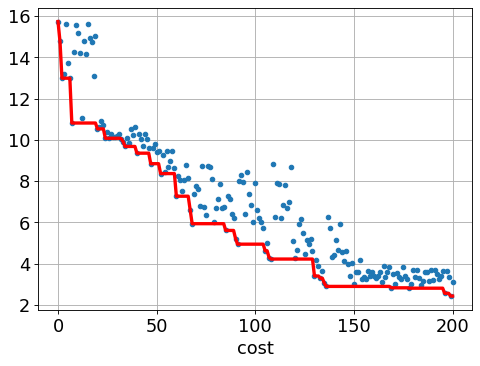

In [22]:
pl.figure(figsize=(7, 5), dpi=80)
matplotlib.rcParams.update({'font.size': 16})
pl.plot([t[1] for t in history], ".", lw=0.5, markersize=8)
pl.xlabel("cost")

pl.plot(np.minimum.accumulate([t[1] for t in history]), 'r', lw=3)
# pl.ylabel("function value")
# pl.ylim([0, 100])
pl.grid(True)

In [17]:
Xtr.shape, R

((200, 10), 21.186303453499388)

## Minima of GD

In [18]:
Xtr[0], Xtr[1], 

(array([-0.1518,  0.6955, -0.1417,  0.0198, -0.1638,  0.5834,  0.1647,
        -0.1113,  0.1647,  0.0164]),
 array([ 0.0152,  0.4717, -0.2846, -0.4444, -0.0064, -0.0106,  0.1547,
        -0.1106,  0.0779,  0.0651]))

In [19]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

(array([1.0371, 0.2795, 0.7825, 0.9545, 1.0633, 0.9723, 3.6226, 1.0092,
        3.6804, 1.5064]),
 1.0510393584239275,
 109)

In [20]:
gp.get_normal()

(1.981279473567873, 1.277269082446665)

In [19]:
# # only for backtracking
# pl.figure(figsize=(10, 6), dpi=80)
# # pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

### TuRBO

### *Thompson Sampling, UCB*

In [17]:
### Thompson Sampling
import os
gp.clear()
# gp.set_hyper(ls, var) # if online update hyper, skip

# init cost
# X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
X = X_fix

gp.set_data(X, f(X))
gp.optimize()
gp.fit()

history_ucb = []
for a in X_fix:
    history_ucb.append( (a, f(a)) )

In [21]:
cost = setup 

while cost < MAX:
    # 1. Thompson Sampling
    w = gp.thompson_sample(n_mesh=2000)
    # 2. GP_UCB
#     b = np.log(cost**gp.dim)
#     w, fw = gp.ucb_minimize(b)
#     w, fw = gp.EI_minimize(y_best=np.min(f(gp.X)))
    if is_new(w, gp.X) == False:
        print('visit before, ignore ', w)
        continue
    

#     fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(24, 21))

#     # plot function (ax1, ax2)
#     im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax2)

#     im1 = ax1.contour(X1, X2, functions.Ackley_2().func(Grid).reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax1)
#     fig.colorbar(im2, ax=ax1)

#     ax1.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax1.plot(w[0], w[1], 'ro')
#     ax1.title.set_text("Noisy Ackley")
#     ax2.title.set_text("Standard Deviation")
    
    
#     # plot derivative in (ax3, ax4), (ax5, ax6)
#     im = ax4.pcolormesh(X1, X2, s_grad_1.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax4)
#     im1 = ax3.contour(X1, X2, g1.reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax3.contour(X1, X2, mu_grad_1.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax3)
#     fig.colorbar(im2, ax=ax3)

#     ax3.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax3.title.set_text("Mean of Posterior Partial x")
#     ax4.title.set_text("Std of Posterior Partial x")

    
#     im3 = ax6.pcolormesh(X1, X2, s_grad_2.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im3, ax=ax6)
#     im4 = ax5.contour(X1, X2, g2.reshape(X1.shape), cmap="PuBuGn")
#     im5 = ax5.contour(X1, X2, mu_grad_2.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im4, ax=ax5)
#     fig.colorbar(im5, ax=ax5)

#     ax5.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax5.title.set_text("Mean of Posterior Partial y")
#     ax6.title.set_text("Std of Posterior Partial y")

#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     pl.savefig('2D_Plots/Ackley/' + filename)
#     pl.show()  
    print(cost, end = '. ')
    print('w: ', w)
    print('  f(w): ', f(w).item())
    print('  y_best: ', np.min(f(gp.X)))
    print()
    
    history_ucb.append( (w, f(w)) )
    gp.add_data(w.reshape(1, dim), f(w))
    
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    cost += 1

10. w:  [-2.9708  7.9098  9.4221 -4.0053  1.6135 -3.4827 -4.0064 -4.5825  6.7736
  3.2006]
  f(w):  14.750124728125018
  y_best:  12.745884822492366

11. w:  [ 3.4942  0.8941  2.9477  1.1468  2.9419  9.0332  8.535   5.0797 -3.0149
 -1.6345]
  f(w):  13.534869049727783
  y_best:  12.745884822492366

12. w:  [ 3.1126e-02  4.6312e-01  5.9026e+00 -3.6032e+00  7.7876e+00  9.6626e+00
  5.1374e+00  2.2563e-03  3.3669e-01  5.2061e+00]
  f(w):  14.321720718351742
  y_best:  12.745884822492366

  # Optimal (ls, var) =  (0.6426335219372731, 0.9999999818513834)
13. w:  [ 5.9089 -0.899  -1.6398 -3.0889  6.2784  2.5464  1.6812  3.4562  8.7511
  1.3984]
  f(w):  13.434938602650307
  y_best:  12.745884822492366

14. w:  [-3.1661  9.0737  7.7185  9.0847  0.857   4.8028 -0.5554  2.016   0.4084
  8.0717]
  f(w):  14.988935800406532
  y_best:  12.745884822492366

15. w:  [-3.921   1.4678 -4.6091  9.5364  0.286   8.5358 -0.8271  0.1427  0.914
  9.9346]
  f(w):  15.083842228605235
  y_best:  12.745884822492

59. w:  [ 4.9879  3.3068  9.9317 -0.1059 -3.6545  1.5059  5.7612  3.9657  2.2322
  3.4209]
  f(w):  13.706411634689882
  y_best:  9.647632107904009

60. w:  [ 0.4492 -3.2203  4.7759  3.5798  5.838  -4.3799  0.9159  9.025  -3.5863
 -1.8605]
  f(w):  13.510822959553572
  y_best:  9.647632107904009

  # Optimal (ls, var) =  (0.9772620664418414, 0.9999999759931035)
61. w:  [ 8.5755  7.9293 -1.1431  0.6078 -2.5505  8.2137  7.6275 -0.3505  4.3384
 -0.6356]
  f(w):  15.184916808573336
  y_best:  9.647632107904009

62. w:  [ 4.8916 -4.9046  5.4557  7.7557 -4.3698  1.3536 -1.1063  2.0261  0.897
  3.2907]
  f(w):  12.885730268811445
  y_best:  9.647632107904009

63. w:  [-0.3909  3.5814  2.9704  0.7839  7.8519  1.0819  4.4976 -1.0415  7.7077
  6.3674]
  f(w):  13.653844904387608
  y_best:  9.647632107904009

  # Optimal (ls, var) =  (0.20581195458945886, 0.9999999649915683)
64. w:  [-0.0161  4.3573  9.0148 -2.5212 -2.3173 -4.3924  7.6042  1.7851  3.9109
  0.8288]
  f(w):  13.69635897703931
  y_b

108. w:  [ 8.9659  1.4594  4.8498  9.7979  5.5023  5.6196 -2.6438 -1.9207 -0.6272
  2.3683]
  f(w):  14.962241725194941
  y_best:  9.647632107904009

  # Optimal (ls, var) =  (0.5405869325550121, 0.9999997917718901)
109. w:  [ 0.904   2.4655  8.8249  4.5083  4.5666 -2.6822  0.975   1.0449  1.8887
 -2.349 ]
  f(w):  12.351243019189447
  y_best:  9.647632107904009

110. w:  [-3.7682 -1.477   9.0385  3.5885  6.4691  4.8319 -2.9018  6.8395  5.9398
  0.0217]
  f(w):  14.372970241652068
  y_best:  9.647632107904009

111. w:  [ 3.2503  3.4048  7.2971  5.9731 -2.2325  0.9552  6.9746  5.3146 -4.6826
  6.7321]
  f(w):  14.41497781135115
  y_best:  9.647632107904009

  # Optimal (ls, var) =  (0.4141303199509775, 0.9999997999783554)
112. w:  [ 5.0637 -2.5097  1.4028  8.0104  7.587   4.1263  8.7855  2.245   0.3354
 -2.8714]
  f(w):  14.511788332113944
  y_best:  9.647632107904009

113. w:  [ 1.7115 -0.3857  1.7157  0.9161  0.988   1.3037 -3.8065  8.459   8.0337
 -0.8547]
  f(w):  12.612649206980592

157. w:  [ 8.0071 -0.546  -1.6022  3.5097 -0.2311 -1.915   2.1834  2.9473  5.4076
 -0.8743]
  f(w):  11.852825974210488
  y_best:  8.561644727531025

158. w:  [ 8.1743  4.9979 -0.2292  7.215   4.4802  1.3067 -2.8826  2.4956 -4.4612
  2.571 ]
  f(w):  13.81618339211242
  y_best:  8.561644727531025

159. w:  [-1.8272 -2.7431  1.3168  7.8705  2.3147 -0.4539  7.368  -3.6816  0.5337
  7.705 ]
  f(w):  13.937053389112867
  y_best:  8.561644727531025

  # Optimal (ls, var) =  (0.11335976919392692, 1.0000001613746003)
160. w:  [1.2842 8.333  6.724  8.5464 4.1216 7.7735 6.7484 8.1427 6.8795 1.3261]
  f(w):  16.319074838383333
  y_best:  8.561644727531025

161. w:  [-1.3369  0.2036 -4.5978  1.3343 -3.391   6.0568 -2.4938  9.4119  0.7552
  6.2504]
  f(w):  13.948614978448248
  y_best:  8.561644727531025

162. w:  [ 9.6474  2.899  -2.5886  1.455   7.0048 -3.379   1.5569  8.5708  8.2226
  3.6298]
  f(w):  15.658503229528659
  y_best:  8.561644727531025

  # Optimal (ls, var) =  (0.9023521054070449,

206. w:  [-4.256  -3.6885  1.6796  8.0072  4.1123  0.5884 -3.4658  0.5544  4.3569
  3.2187]
  f(w):  12.880564075571979
  y_best:  8.561644727531025

207. w:  [-0.3621 -2.5829  8.243  -1.8504 -4.1462 -2.1817  2.0913  7.2818 -4.0397
 -3.7482]
  f(w):  13.123244750528434
  y_best:  8.561644727531025

  # Optimal (ls, var) =  (0.7056917247126596, 0.9999999973367932)
208. w:  [-4.5288 -0.0347  0.4526  3.2929 -0.8281  0.6536 -3.9818  4.9883  5.4929
 -1.6464]
  f(w):  11.38868105550549
  y_best:  8.561644727531025

209. w:  [-4.6335  5.9896  6.0151  2.9782  4.341  -2.5491  7.3855  5.5177  2.3968
  6.2013]
  f(w):  14.593632509956668
  y_best:  8.561644727531025

210. w:  [ 6.1281 -4.5432  7.2625  7.323   5.8744 -1.7453  2.9082  7.7809  8.9607
 -4.729 ]
  f(w):  15.638364420091523
  y_best:  8.561644727531025

  # Optimal (ls, var) =  (0.6541203690178549, 0.999999951620793)
211. w:  [ 5.1225 -1.5263 -1.0112  7.3467  1.54    6.9994 -1.609   4.6814  8.0811
  2.3548]
  f(w):  14.129977876508057


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/hangdong/anaconda3/envs/BO/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-46d9a4d6ddf1>", line 72, in <module>
    ls, var = gp.optimize()
  File "/home/hangdong/gp/Code/GP.py", line 150, in optimize
    loglik = np.append(loglik, self.log_lik(hyper_values=x))
  File "/home/hangdong/gp/Code/GP.py", line 126, in log_lik
    KK_x_x = self.cov_RBF(self._X, self._X, hyper) + np.eye(len(self._X)) * self.noise_delta**2
  File "/home/hangdong/gp/Code/GP.py", line 113, in cov_RBF
    assert np.all(x2 >= self._B[:, 0]) and np.all(x2 <= self._B[:, 1])
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/hangdong/anaconda3/envs/BO/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_trace

TypeError: object of type 'NoneType' has no len()

In [ ]:
pl.figure(figsize=(10, 7), dpi=80)
pl.plot(np.squeeze(np.array(history_ucb)[:, 1]), "-^", lw=0.5)
pl.plot(np.minimum.accumulate(np.array(history_ucb)[:, 1]), 'r', lw=2)
pl.xlabel("cost")
pl.ylabel("function value")
pl.grid(True)

## Global Minima 

In [ ]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

In [ ]:
gp.get_hyper()

In [ ]:
pl.figure(figsize=(10, 7), dpi=80)
pl.plot(np.minimum.accumulate([t[1].item() for t in history_ucb]), 'r', lw=3, label='Thompson')
pl.plot(np.minimum.accumulate([t[1].item() for t in history]), 'b', lw=3, label='GD')
# pl.title("6D Hartmann function on [0, 1]")
pl.legend()
pl.grid(True)
# pl.ylim([0, 100])

In [ ]:
import pickle
file_name = "./pkl/GD_Ackley5.pkl" 

open_file = open(file_name, "wb")
pickle.dump(np.minimum.accumulate([t[1] for t in history]), open_file)
open_file.close()

open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()

In [ ]:
file_name = "./pkl/thompson_Ackley5.pkl" 

open_file = open(file_name, "wb")
pickle.dump(np.minimum.accumulate([t[1] for t in history_ucb]), open_file)
open_file.close()

open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()